# **CAR PRICE PREDICTION NOTEBOOK**

## **Summary**

1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Model finalization
7. Test on unseen data

.

.

## **1. Importing libraries and data**

In [105]:
#Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [106]:
#Importing data
Data = pd.read_csv("Data.csv", sep=",")                 #Training
Test = pd.read_csv("Test.csv", sep=",")                 #Final Test (unseen data)
Data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


.

.


# **2. Data cleaning and preparation**

In [107]:
#Creation of X and y 
X_train = Data.drop(["SalePrice"],axis=1)
y_train = Data.SalePrice

In [108]:
#Drop "*Id*" and "*MoSold*" columns form the dataset (only "years" will be used in the training session).
X_train.drop(["Id","MoSold"],axis=1,inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [109]:
#There are many missing values that will be treated later. 
#Check for mispelled entries in "object" features.
i=0
while i<X_train.shape[1] :
        if X_train.iloc[:,i].dtype == np.dtype("object") :
            print(X_train.columns[i],": ", X_train.iloc[:,i].unique())
        i=i+1

MSZoning :  ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
LotShape :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'

In [110]:
#Using the description file, the dataset contains the following mispelled words:
# - MSZoning:      "C (all)"  for  "C"
# - Neighborhood:  "Names"    for  "NAmes"
# - Exterior1st:   "CemntBd"  for  "CmentBd"
# - Exterior2st:   "Wd Shng"  for  "Wd Sdng"
# - Exterior2st:   "Brk Cmn"  for  "BrkComm"

#Correction
X_train.MSZoning[np.where(X_train.MSZoning == "C (all)")[0]] = "C"
X_train.Neighborhood[np.where(X_train.Neighborhood == "Names")[0]] = "NAmes"
X_train.Exterior1st[np.where(X_train.Exterior1st == "CemntBd")[0]] = "CmentBd"
X_train.Exterior2nd[np.where(X_train.Exterior2nd == "Wd Shng")[0]] = "Wd Sdng"
X_train.Exterior2nd[np.where(X_train.Exterior2nd == "Brk Cmn")[0]] = "BrkComm"

In [111]:
#There are a lot of missing values: those are related to some missing house features (e.g. pool, fireplace, basement,...).
#For example: if a house does not have a pool, the dataset has NaN in the pool quality column.
#This suggests that it is not wise to use a mean/median/mode value to fill those missing values.
#Instead, it is possible to assign "0" to them (meaning "absent","unknown",...).

#Percentage of missing values
print("The percentage of missing values is: {:.2f}%".format(100*X_train.isna().sum().sum()/(X_train.shape[0]*X_train.shape[1])))

The percentage of missing values is: 6.12%


In [112]:
#Some of the categorical features have a rank order (e.g. Excellent, Good, Average,...).
#Let's take a look at those "object" categories.
i=0
while i<X_train.shape[1] :
    if X_train.iloc[:,i].dtype == np.dtype("object") :
        print(X_train.columns[i],": ", X_train.iloc[:,i].unique())
    i=i+1

MSZoning :  ['RL' 'RM' 'C' 'FV' 'RH']
Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
LotShape :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'Cly

In [113]:
#Based on the results above and the data description file, the categorical features with a rank order are: 
#  "LotShape","LandSlope","HouseStyle","ExterQual","ExterCond","BsmtQual","BsmtCond,
#  "BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","Functional",
#  "FireplaceQu","GarageFinish","GarageQual","GarageCond","PoolQC","Fence"

#Each class (for each categorical feature) will be replaced with a number larger than 0 
#The rank order will be preserved (using the same order as reported in the data description file).
#Missing values (NaN) will be replaced with "0".

#Rank order
X_train.LotShape.replace(['Reg','IR1','IR2','IR3'],[4,3,2,1],inplace=True)
X_train.LandContour.replace(['Lvl','Bnk','HLS','Low'],[1,2,3,4],inplace=True)
X_train.LandSlope.replace(['Gtl','Mod','Sev'],[1,2,3],inplace=True)
X_train.BldgType.replace(['1Fam','2fmCon','Duplex','TwnhsE','Twnhs'],[1,2,3,4,5],inplace=True)
X_train.HouseStyle.replace(['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],[1,2,3,4,5,6,7,8],inplace=True)
X_train.ExterQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.ExterCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.BsmtQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.BsmtCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.BsmtExposure.replace(['Gd','Av','Mn','No'],[3,2,1,0],inplace=True)            #No exposure = 0
X_train.BsmtFinType1.replace(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'],[6,5,4,3,2,1],inplace=True)
X_train.BsmtFinType2.replace(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'],[6,5,4,3,2,1],inplace=True)
X_train.HeatingQC.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.KitchenQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.Functional.replace(['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],[8,7,6,5,4,3,2,1],inplace=True)
X_train.FireplaceQu.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.GarageFinish.replace(['Fin','RFn','Unf'],[3,2,1],inplace=True)
X_train.GarageQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.GarageCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.PoolQC.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
X_train.Fence.replace(['GdPrv','MnPrv','GdWo','MnWw'],[4,3,2,1],inplace=True)
    
#Missing values
for i in ["LotShape","LandSlope","HouseStyle","ExterQual","ExterCond","BsmtQual","BsmtCond",
          "BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","Functional",
          "FireplaceQu","GarageFinish","GarageQual","GarageCond","PoolQC","Fence"] :
    X_train[i].fillna(0, inplace=True)

In [114]:
#Percentage of missing values
print("The percentage of missing values is: {:.2f}%".format(100*X_train.isna().sum().sum()/(X_train.shape[0]*X_train.shape[1])))

The percentage of missing values is: 2.82%


In [115]:
#Let's take a look at the remaining "object" categorical features
i=0
while i<X_train.shape[1] :
        if X_train.iloc[:,i].dtype == np.dtype("object") :
            print(X_train.columns[i], ": ", X_train.iloc[:,i].unique())
        i=i+1

MSZoning :  ['RL' 'RM' 'C' 'FV' 'RH']
Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st :  ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CmentBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd :  ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'CmentBd' 'BrkFa

In [116]:
#The same replacemente method will be used for those categorical features that have common classes.
#Missing values NaN will be replaced with "0".

#Categorical features (alphabetic order)
X_train.MSZoning.replace(['A','C','FV','I','RH','RL','RP','RM'],np.arange(1,9),inplace=True)
X_train.Street.replace(['Grvl','Pave'],[1,2],inplace=True)
X_train.Alley.replace(['Grvl','Pave'],[1,2],inplace=True)
X_train.Utilities.replace(['AllPub','NoSewr','NoSeWa','ELO'],np.arange(1,5),inplace=True)
X_train.LotConfig.replace(['Inside','Corner','CulDSac','FR2','FR3'],np.arange(1,6),inplace=True)
X_train.Neighborhood.replace(['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards',
                              'Gilbert','IDOTRR','MeadowV','Mitchel','NAmes','NoRidge','NPkVill','NridgHt','NWAmes',
                              'OldTown','SWISU','Sawyer','SawyerW','Somerst','StoneBr','Timber','Veenker'],np.arange(1,26),inplace=True)
X_train.Condition1.replace(['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],np.arange(1,10),inplace=True)
X_train.Condition2.replace(['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],np.arange(1,10),inplace=True)
X_train.RoofStyle.replace(['Flat','Gable','Gambrel','Hip','Mansard','Shed'],np.arange(1,7),inplace=True)
X_train.RoofMatl.replace(['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl',],np.arange(1,9),inplace=True)
X_train.Exterior1st.replace(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CmentBd','HdBoard','ImStucc',
                             'MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],np.arange(1,18),inplace=True)
X_train.Exterior2nd.replace(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CmentBd','HdBoard','ImStucc',
                             'MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],np.arange(1,18),inplace=True)
X_train.MasVnrType.replace(['BrkCmn','BrkFace','CBlock','Stone','None'],[1,2,3,4,0],inplace=True)
X_train.Foundation.replace(['BrkTil','CBlock','PConc','Slab','Stone','Wood'],np.arange(1,7),inplace=True)
X_train.Heating.replace(['Floor','GasA','GasW','Grav','OthW','Wall'],np.arange(1,7),inplace=True)
X_train.CentralAir.replace(['Y','N'],[1,0],inplace=True)
X_train.Electrical.replace(['SBrkr','FuseA','FuseF','FuseP','Mix'],np.arange(1,6),inplace=True)
X_train.GarageType.replace(['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd'],np.arange(1,7),inplace=True)
X_train.PavedDrive.replace(['Y','P','N'], np.arange(1,4),inplace=True)
X_train.MiscFeature.replace(['Elev','Gar2','Othr','Shed','TenC'],np.arange(1,6),inplace=True)        
X_train.SaleType.replace(['WD','CWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'],np.arange(1,10),inplace=True)
X_train.SaleCondition.replace(['Normal','Abnorml','AdjLand','Alloca','Family','Partial'],np.arange(1,7),inplace=True)
                         
#Missing values
for i in ["MSZoning","Street","Alley","Utilities","LotConfig","Neighborhood","Condition1","Condition2",
          "RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating","CentralAir",
          "Electrical","GarageType","PavedDrive","MiscFeature","SaleType","SaleCondition"] :
    X_train[i].fillna(0, inplace=True)

In [117]:
#Percentage of missing values
print("The percentage of missing values is: {:.2f}%".format(100*X_train.isna().sum().sum()/(X_train.shape[0]*X_train.shape[1])))

The percentage of missing values is: 0.31%


In [118]:
#Last missing values in column:
X_train.columns[X_train.isna().sum()>0]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [119]:
#There is the possility that NaN values in 'MasVnrArea' (i.e. area of the Masonrt veneer) are there because
#they are related to the missing Masonry veneer (*MasVnrType* raplaced with "0" previously).

#Print the MasVnrType for the missing MasVnrArea values:
X_train.MasVnrType.loc[X_train.MasVnrArea.isna()]

234     0.0
529     0.0
650     0.0
936     0.0
973     0.0
977     0.0
1243    0.0
1278    0.0
Name: MasVnrType, dtype: float64

In [120]:
#As expected. Replace missing *MasVnrArea* values with 0
X_train.MasVnrArea.fillna(0,inplace=True)

In [121]:
#Correlation coefficients of "GarageYrBlt" with the other features
#Correlation matrix
X_train.corr()["GarageYrBlt"].sort_values()

GarageType     -0.359487
Electrical     -0.329455
OverallCond    -0.324297
PavedDrive     -0.300103
MSZoning       -0.298977
                  ...   
GarageCars      0.588920
Foundation      0.591845
YearRemodAdd    0.642277
YearBuilt       0.825667
GarageYrBlt     1.000000
Name: GarageYrBlt, Length: 78, dtype: float64

Text(0, 0.5, 'House YearBuilt')

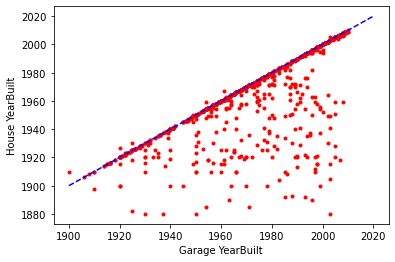

In [122]:
#It is strongly correlated with "YearBuilt"
plt.plot(X_train.GarageYrBlt,X_train.YearBuilt,'.r')
plt.plot([1900,2020],[1900,2020],'--b')                   #Unity line
plt.xlabel("Garage YearBuilt")
plt.ylabel("House YearBuilt")

In [123]:
#Despite the outliers, the garage "YearBuilt" is the same as the house one (the majority of data lies on the unity line).
#Without loosing much information, drop "GarageYrBlt" and keep only the "YearBuilt" feature.
X_train = X_train.drop(["GarageYrBlt"],axis=1)

In [124]:
#Correlation coefficient of "LotFrontage" with the other features
#Correlation matrix
X_train.corr()["LotFrontage"].sort_values()

BldgType      -0.471250
MSSubClass    -0.386347
LotShape      -0.231878
GarageType    -0.192705
Alley         -0.190957
                 ...   
GrLivArea      0.402797
LotArea        0.426095
1stFlrSF       0.457181
LotFrontage    1.000000
Utilities           NaN
Name: LotFrontage, Length: 77, dtype: float64

The mean value is: 70.04995836802665
The median value is: 69.0


<AxesSubplot:xlabel='LotFrontage', ylabel='Count'>

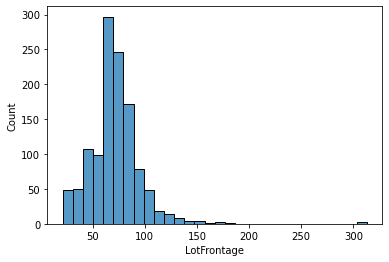

In [125]:
#No strong correlations (i.e. coefficient >0.8). 
#Print the mean, the median, and take a look at the data distribution
print("The mean value is: {}".format(X_train.LotFrontage.mean()))
print("The median value is: {}".format(X_train.LotFrontage.median()))
sn.histplot(data = Data, x = "LotFrontage", bins=30)

In [126]:
#The Mean and the Median are very similar (the distribution between 0 and 150 is Gaussian-like, despite the outliers at ~300)
#For what concerns "LotFrontage" missing values: it is very unlikely that the distance from the street is equal to zero
#Therefore, it is possible to replace those missing values with the median value.
Median_lotfrontage = X_train.LotFrontage.median()                        #This will be used later
X_train.LotFrontage.fillna(Median_lotfrontage, inplace=True) 

In [127]:
#Number of missing values
print("The Number of missing values is: {}".format(X_train.isna().sum().sum()))

The Number of missing values is: 0


In [128]:
#No missing values

#Let's take a look Correlation Matrix and check if there are strong correlations between features (i.e., coefficient >0.8)
#If present, they must be studied and possibly removed from the dataset.
High_corr = pd.DataFrame([X_train.columns[np.where((abs(X_train.corr())>=0.8))[0]],
                          X_train.columns[np.where((abs(X_train.corr())>=0.8))[1]]],
                          index=["Val1","Val2"]).T

High_corr.drop(np.where(High_corr.Val1 == High_corr.Val2)[0],axis=0, inplace=True)        #Remove diagonal correlations
High_corr

,Val1,Val2
23,Exterior1st,Exterior2nd
24,Exterior2nd,Exterior1st
40,TotalBsmtSF,1stFlrSF
45,1stFlrSF,TotalBsmtSF
50,GrLivArea,TotRmsAbvGrd
58,TotRmsAbvGrd,GrLivArea
62,Fireplaces,FireplaceQu
63,FireplaceQu,Fireplaces
68,GarageCars,GarageArea
69,GarageArea,GarageCars


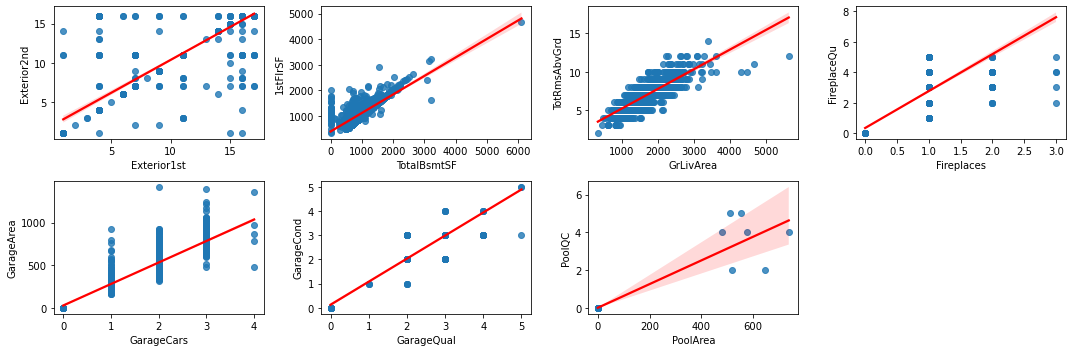

In [129]:
#Let's take a look at their plots
plt.figure(figsize=(15,5))  

plt.subplot(2,4,1)
sn.regplot(data = X_train, x = "Exterior1st", y = "Exterior2nd", line_kws={"color": "red"})
plt.xlabel("Exterior1st")
plt.ylabel("Exterior2nd")

plt.subplot(2,4,2)
sn.regplot(data = X_train, x = "TotalBsmtSF", y = "1stFlrSF", line_kws={"color": "red"})
plt.xlabel("TotalBsmtSF")
plt.ylabel("1stFlrSF")

plt.subplot(2,4,3)
sn.regplot(data = X_train, x = "GrLivArea", y = "TotRmsAbvGrd", line_kws={"color": "red"})
plt.xlabel("GrLivArea")
plt.ylabel("TotRmsAbvGrd")

plt.subplot(2,4,4)
sn.regplot(data = X_train, x = "Fireplaces", y = "FireplaceQu", line_kws={"color": "red"})
plt.xlabel("Fireplaces")
plt.ylabel("FireplaceQu")

plt.subplot(2,4,5)
sn.regplot(data = X_train, x = "GarageCars", y = "GarageArea", line_kws={"color": "red"})
plt.xlabel("GarageCars")
plt.ylabel("GarageArea")

plt.subplot(2,4,6)
sn.regplot(data = X_train, x = "GarageQual", y = "GarageCond", line_kws={"color": "red"})
plt.xlabel("GarageQual")
plt.ylabel("GarageCond")

plt.subplot(2,4,7)
sn.regplot(data = X_train, x = "PoolArea", y = "PoolQC", line_kws={"color": "red"})
plt.xlabel("PoolArea")
plt.ylabel("PoolQC")

plt.tight_layout()

In [130]:
#There is a large scatter in all plots.
#For what concerns "GarageCars vs. GarageArea": 
#  - The number of cars that can fitted in a garage is too generic  given that it may depend on the car size, shape, etc.. Therefore it is possible to drop "GarageCars".
#For what concerns "GarageQual vs. GarageCond":
#  - they are almost the same therefore, it is possible to keep only one of them (drop "GarageQual")

X_train.drop(["GarageCars","GarageQual"],axis=1, inplace=True)

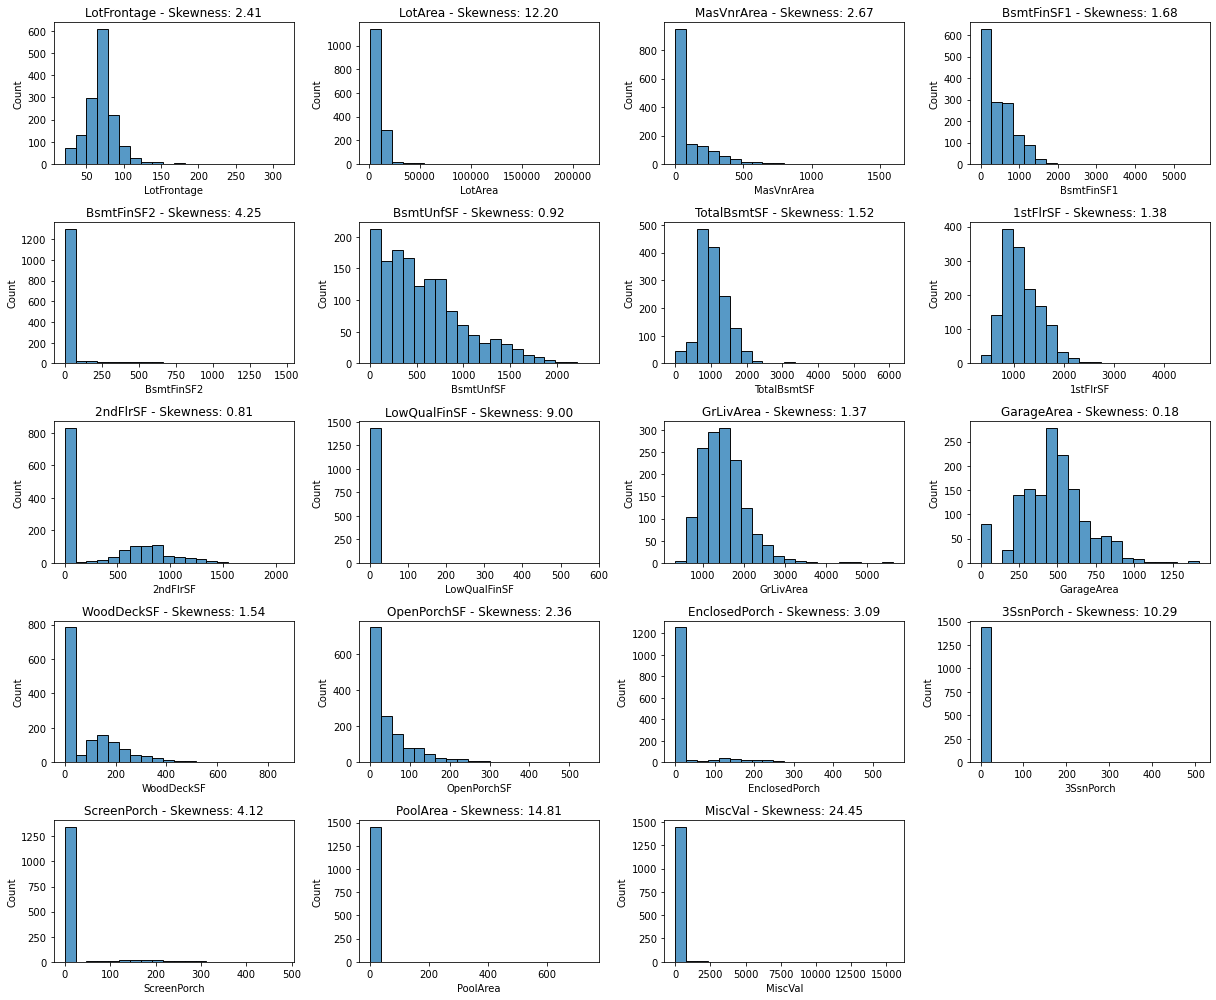

In [131]:
#Data Distribution for numerical features
#They are:
# "LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
# "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
# "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"

#It is important to remember that a lot of records are equal to 0 because they are related to an absent house feature (see previous sections).
#Let's take a look at the plots and compute their skewness
plt.figure(figsize=(17,14))  
j=1
for i in ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
          "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
          "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"] :
    plt.subplot(5,4,j)
    sn.histplot(data=X_train, x=i, bins=20)
    a = skew(X_train[i])
    plt.title("{} - Skewness: {:.2f}".format(i,a))             #Skewness in the title
    j = j+1

plt.tight_layout()

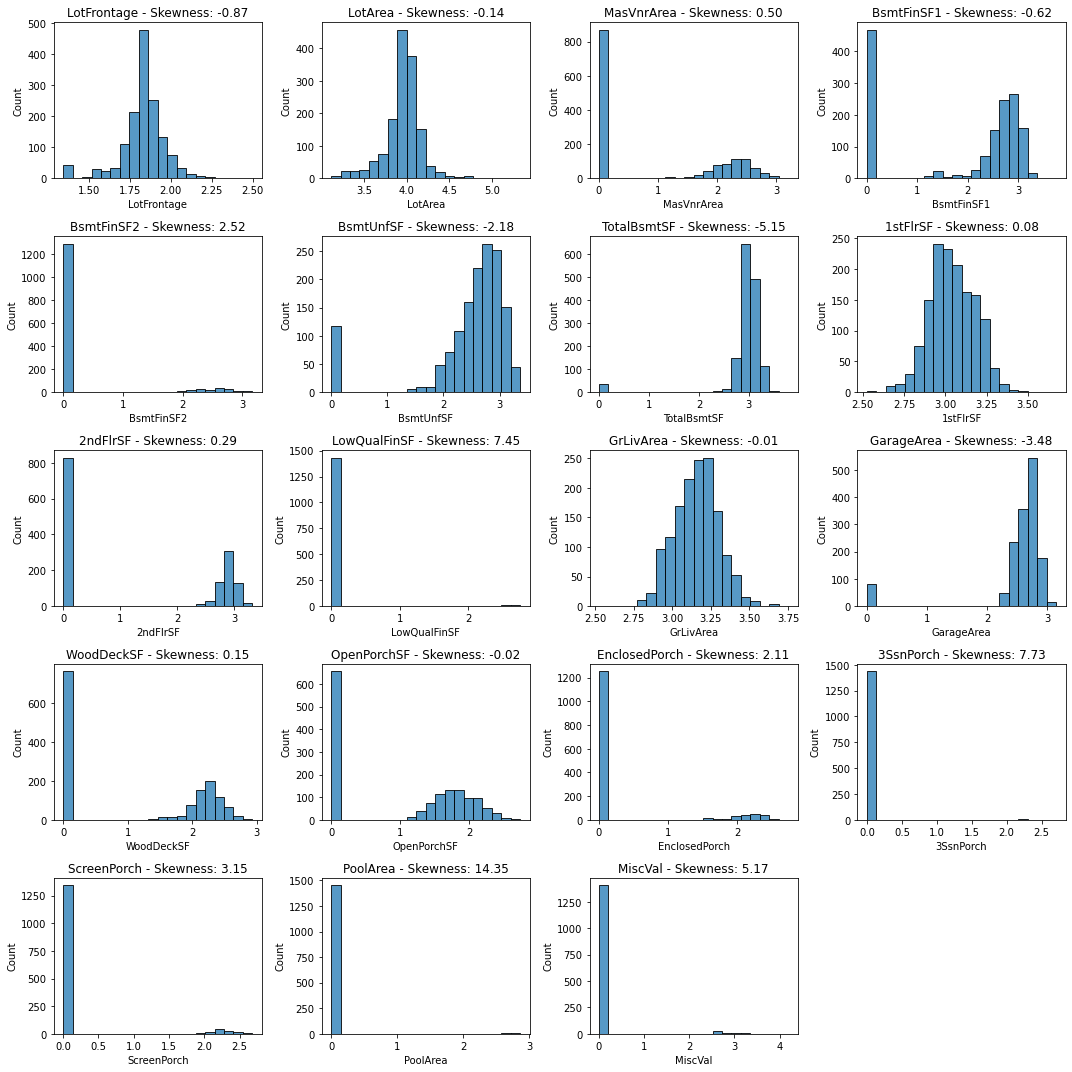

In [132]:
#Given the different ranges spanned by the above features, it is possible to log-transform their values and reduce numbers to ranges between 0 and 5
#It will be used the log10(x+1) tranformation to avoid errors with values equal to 0
#Using a different scaling (e.g., MinMaxScaler, StandardScaler) does not change drastically the final performance.

plt.figure(figsize=(15,15))  
j=1
for i in ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
          "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
          "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"] :
    X_train[i] = np.log10(X_train[i]+1)
    plt.subplot(5,4,j)
    sn.histplot(data=X_train, x= i,bins=20)
    a = skew(X_train[i])
    plt.title("{} - Skewness: {:.2f}".format(i,a))             #Skewness in the title
    j = j+1

plt.tight_layout()

In [133]:
#The log-transformation reduced the skewness drastically for some features. 
#For others, it did not happen because of the large number of values equal to 0.

#Given the above distributions, there might be some outliers (especially for those features with a large number of 0s)
#Given that those 0 values contain information about the quality/condition of the houses, they will not be removed.

#Let's take a look at the ranges spanned by each feature
for i in X_train.columns :
    print("Feature: ",i, "    - Max:", max(X_train[i]), "| Min:",min(X_train[i]))

Feature:  MSSubClass     - Max: 190 | Min: 20
Feature:  MSZoning     - Max: 8 | Min: 2
Feature:  LotFrontage     - Max: 2.496929648073215 | Min: 1.3424226808222062
Feature:  LotArea     - Max: 5.332935089537684 | Min: 3.1142772965615864
Feature:  Street     - Max: 2 | Min: 1
Feature:  Alley     - Max: 2.0 | Min: 0.0
Feature:  LotShape     - Max: 4 | Min: 1
Feature:  LandContour     - Max: 4 | Min: 1
Feature:  Utilities     - Max: 3 | Min: 1
Feature:  LotConfig     - Max: 5 | Min: 1
Feature:  LandSlope     - Max: 3 | Min: 1
Feature:  Neighborhood     - Max: 25 | Min: 1
Feature:  Condition1     - Max: 9 | Min: 1
Feature:  Condition2     - Max: 9 | Min: 1
Feature:  BldgType     - Max: 5 | Min: 1
Feature:  HouseStyle     - Max: 8 | Min: 1
Feature:  OverallQual     - Max: 10 | Min: 1
Feature:  OverallCond     - Max: 9 | Min: 1
Feature:  YearBuilt     - Max: 2010 | Min: 1872
Feature:  YearRemodAdd     - Max: 2010 | Min: 1950
Feature:  RoofStyle     - Max: 6 | Min: 1
Feature:  RoofMatl     - 

In [134]:
#The majority of the values lie within a range between 0 and ~10.
# - Three features (i.e., "Exterior1st", "Exterior2nd", "Neighborhood") have values in a range between 1 and ~30
# - One feature (i.e., "MSSubClass") has values in the range between 20 and ~200
# - Three features (i.e., "YearBuilt", "YearRemodAdd", "YrSold") have values in ranges between 1892 and 2010 (years).

#The next steps will be:
# - Substitute the "MSSubClass" values with numbers between 1 and 15
# - Transform years categories by normalizing them with respect to 2010 (the last year in the dataset) and them use MinMaxScaler

#MSSubClass categories
MSS_classes = X_train.MSSubClass.sort_values().unique()            #It will be used later
X_train.MSSubClass.replace(MSS_classes,np.arange(1,len(MSS_classes)+1), inplace=True)

#Years normalization
X_train.YearBuilt = 2010 - X_train.YearBuilt
X_train.YearRemodAdd = 2010 - X_train.YearRemodAdd
X_train.YrSold = 2010 - X_train.YrSold

#Let's take a look at the ranges spanned by each feature
for i in X_train.columns :
    print("Feature: ",i, "    - Max:", max(X_train[i]), "| Min:",min(X_train[i]))

Feature:  MSSubClass     - Max: 15 | Min: 1
Feature:  MSZoning     - Max: 8 | Min: 2
Feature:  LotFrontage     - Max: 2.496929648073215 | Min: 1.3424226808222062
Feature:  LotArea     - Max: 5.332935089537684 | Min: 3.1142772965615864
Feature:  Street     - Max: 2 | Min: 1
Feature:  Alley     - Max: 2.0 | Min: 0.0
Feature:  LotShape     - Max: 4 | Min: 1
Feature:  LandContour     - Max: 4 | Min: 1
Feature:  Utilities     - Max: 3 | Min: 1
Feature:  LotConfig     - Max: 5 | Min: 1
Feature:  LandSlope     - Max: 3 | Min: 1
Feature:  Neighborhood     - Max: 25 | Min: 1
Feature:  Condition1     - Max: 9 | Min: 1
Feature:  Condition2     - Max: 9 | Min: 1
Feature:  BldgType     - Max: 5 | Min: 1
Feature:  HouseStyle     - Max: 8 | Min: 1
Feature:  OverallQual     - Max: 10 | Min: 1
Feature:  OverallCond     - Max: 9 | Min: 1
Feature:  YearBuilt     - Max: 138 | Min: 0
Feature:  YearRemodAdd     - Max: 60 | Min: 0
Feature:  RoofStyle     - Max: 6 | Min: 1
Feature:  RoofMatl     - Max: 8 | Mi

The skewness is: 1.880940746034036


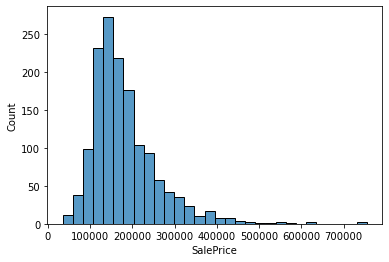

In [135]:
#Target variable: "SalePrice"
sn.histplot(x=y_train,bins=30)
print("The skewness is: {}".format(skew(y_train)))

The skewness is: 0.12121036730137286


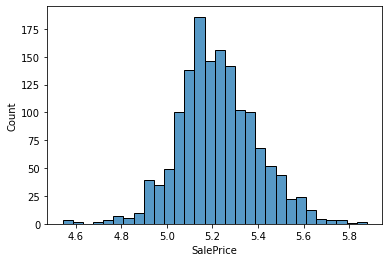

In [136]:
#It spans a large range. Let's apply a log-transformation
y_train = np.log10(y_train)
sn.histplot(x=y_train,bins=30)
print("The skewness is: {}".format(skew(y_train)))

In [137]:
#skewness reduced

#Feature selection
#Correlation matrix (correlation coefficient between each feature and the target variable)

Cor_y = abs(pd.concat([X_train,y_train],axis=1).corr()["SalePrice"]).sort_values()
Cor_y[Cor_y<=0.1]

BsmtHalfBath    0.005149
Utilities       0.012632
BsmtFinType2    0.014034
BsmtFinSF2      0.030361
MSSubClass      0.035486
OverallCond     0.036868
YrSold          0.037263
LandSlope       0.038526
ExterCond       0.049314
LowQualFinSF    0.054513
Street          0.057369
LandContour     0.057865
3SsnPorch       0.058827
Condition2      0.059703
MiscVal         0.067054
PoolArea        0.069949
MiscFeature     0.074911
PoolQC          0.077291
SaleType        0.089007
HouseStyle      0.091101
Alley           0.091145
Name: SalePrice, dtype: float64

In [138]:
#Use f_regression function
from sklearn.feature_selection import f_regression

Pval = pd.DataFrame(f_regression(X_train,y_train)[1],index=X_train.columns,columns=["P-value"])
Pval.iloc[np.where(Pval>=0.01)[0]]

,P-value
MSSubClass,0.175365
Street,0.028379
LandContour,0.027037
Utilities,0.629609
LandSlope,0.141193
Condition2,0.022530
OverallCond,0.159132
ExterCond,0.059592
BsmtFinType2,0.592090
BsmtFinSF2,0.246315


In [139]:
#A smaller number with respect to the correlation matrix results
#Let's drop those features with a p-value larger than 0.01
Drop_pval = Pval.iloc[np.where(Pval>=0.01)[0]].index
X_train.drop(Drop_pval,axis=1,inplace=True)

In [140]:
#MinMaxScaler
Set_scaler = MinMaxScaler()
Set_scaler.fit(X_train)
X_train = pd.DataFrame(Set_scaler.transform(X_train), columns = X_train.columns)
X_train

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.666667,0.413268,0.366271,0.0,1.000000,0.00,0.208333,0.250,0.0,0.428571,...,0.000000,0.654449,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,0.666667,0.490307,0.391245,0.0,1.000000,0.75,1.000000,0.125,0.0,0.000000,...,0.843935,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,0.666667,0.429990,0.422289,0.0,0.666667,0.00,0.208333,0.250,0.0,0.428571,...,0.000000,0.596422,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,0.666667,0.383633,0.390223,0.0,0.666667,0.25,0.250000,0.250,0.0,0.428571,...,0.000000,0.568247,0.888227,0.0,0.0,0.0,0.00,0.0,0.0,0.2
4,0.666667,0.508439,0.468694,0.0,0.666667,0.75,0.541667,0.250,0.0,0.428571,...,0.779126,0.704481,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.666667,0.395769,0.353519,0.0,1.000000,0.00,0.333333,0.250,0.0,0.428571,...,0.000000,0.588869,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1456,0.666667,0.512839,0.453205,0.0,1.000000,0.00,0.666667,0.250,0.0,0.000000,...,0.867250,0.000000,0.000000,0.0,0.0,0.0,0.75,0.0,0.0,0.0
1457,0.666667,0.418925,0.379525,0.0,1.000000,0.00,0.250000,0.250,0.0,0.428571,...,0.000000,0.651870,0.000000,0.0,0.0,0.0,1.00,0.8,0.0,0.0
1458,0.666667,0.429990,0.393616,0.0,1.000000,0.00,0.500000,0.250,0.0,0.000000,...,0.874272,0.000000,0.748554,0.0,0.0,0.0,0.00,0.0,0.0,0.0


.

.

## **3. Data transformation function**

In [141]:
#Before going on, it is possible to define a function containing all the procedures and transformation 
#performed on the Training set: this function will be used for transforming the Test set before applying the final model

def Data_transformation(X,y) :                 #Input variables and target variable as inputs
    #(0) Drop useless columns & corrections
    X.drop(["Id","MoSold"],axis=1,inplace=True)
    X.MSZoning[np.where(X.MSZoning == "C (all)")[0]] = "C"
    X.Neighborhood[np.where(X.Neighborhood == "Names")[0]] = "NAmes"
    X.Exterior1st[np.where(X.Exterior1st == "CemntBd")[0]] = "CmentBd"
    X.Exterior2nd[np.where(X.Exterior2nd == "Wd Shng")[0]] = "Wd Sdng"
    X.Exterior2nd[np.where(X.Exterior2nd == "Brk Cmn")[0]] = "BrkComm"

    #(1) Ranked categorical features
    X.LotShape.replace(['Reg','IR1','IR2','IR3'],[4,3,2,1],inplace=True)
    X.LandContour.replace(['Lvl','Bnk','HLS','Low'],[1,2,3,4],inplace=True)
    X.LandSlope.replace(['Gtl','Mod','Sev'],[1,2,3],inplace=True)
    X.BldgType.replace(['1Fam','2fmCon','Duplex','TwnhsE','Twnhs'],[1,2,3,4,5],inplace=True)
    X.HouseStyle.replace(['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],[1,2,3,4,5,6,7,8],inplace=True)
    X.ExterQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.ExterCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.BsmtQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.BsmtCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.BsmtExposure.replace(['Gd','Av','Mn','No'],[3,2,1,0],inplace=True)            #No exposure = 0
    X.BsmtFinType1.replace(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'],[6,5,4,3,2,1],inplace=True)
    X.BsmtFinType2.replace(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'],[6,5,4,3,2,1],inplace=True)
    X.HeatingQC.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.KitchenQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.Functional.replace(['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],[8,7,6,5,4,3,2,1],inplace=True)
    X.FireplaceQu.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.GarageFinish.replace(['Fin','RFn','Unf'],[3,2,1],inplace=True)
    X.GarageQual.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.GarageCond.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.PoolQC.replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
    X.Fence.replace(['GdPrv','MnPrv','GdWo','MnWw'],[4,3,2,1],inplace=True)
    
    #Missing values
    for i in ["LotShape","LandSlope","HouseStyle","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure",
              "BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","Functional","FireplaceQu","GarageFinish",
              "GarageQual","GarageCond","PoolQC","Fence"] :
        X[i].fillna(0, inplace=True)

    
    #Categorical features
    X.MSZoning.replace(['A','C','FV','I','RH','RL','RP','RM'],np.arange(1,9),inplace=True)
    X.Street.replace(['Grvl','Pave'],[1,2],inplace=True)
    X.Alley.replace(['Grvl','Pave'],[1,2],inplace=True)
    X.Utilities.replace(['AllPub','NoSewr','NoSeWa','ELO'],np.arange(1,5),inplace=True)
    X.LotConfig.replace(['Inside','Corner','CulDSac','FR2','FR3'],np.arange(1,6),inplace=True)
    X.Neighborhood.replace(['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards',
                                  'Gilbert','IDOTRR','MeadowV','Mitchel','NAmes','NoRidge','NPkVill','NridgHt','NWAmes',
                                  'OldTown','SWISU','Sawyer','SawyerW','Somerst','StoneBr','Timber','Veenker'],np.arange(1,26),inplace=True)
    X.Condition1.replace(['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],np.arange(1,10),inplace=True)
    X.Condition2.replace(['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],np.arange(1,10),inplace=True)
    X.RoofStyle.replace(['Flat','Gable','Gambrel','Hip','Mansard','Shed'],np.arange(1,7),inplace=True)
    X.RoofMatl.replace(['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl',],np.arange(1,9),inplace=True)
    X.Exterior1st.replace(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CmentBd','HdBoard','ImStucc',
                                 'MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],np.arange(1,18),inplace=True)
    X.Exterior2nd.replace(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CmentBd','HdBoard','ImStucc',
                                 'MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],np.arange(1,18),inplace=True)
    X.MasVnrType.replace(['BrkCmn','BrkFace','CBlock','Stone','None'],[1,2,3,4,0],inplace=True)
    X.Foundation.replace(['BrkTil','CBlock','PConc','Slab','Stone','Wood'],np.arange(1,7),inplace=True)
    X.Heating.replace(['Floor','GasA','GasW','Grav','OthW','Wall'],np.arange(1,7),inplace=True)
    X.CentralAir.replace(['Y','N'],[1,0],inplace=True)
    X.Electrical.replace(['SBrkr','FuseA','FuseF','FuseP','Mix'],np.arange(1,6),inplace=True)
    X.GarageType.replace(['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd'],np.arange(1,7),inplace=True)
    X.PavedDrive.replace(['Y','P','N'], np.arange(1,4),inplace=True)
    X.MiscFeature.replace(['Elev','Gar2','Othr','Shed','TenC'],np.arange(1,6),inplace=True)        
    X.SaleType.replace(['WD','CWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'],np.arange(1,10),inplace=True)
    X.SaleCondition.replace(['Normal','Abnorml','AdjLand','Alloca','Family','Partial'],np.arange(1,7),inplace=True)
    
    #Missing values
    for i in ["MSZoning","Street","Alley","Utilities","LotConfig","Neighborhood","Condition1","Condition2",
              "RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating","CentralAir",
              "Electrical","GarageType","PavedDrive","MiscFeature","SaleType","SaleCondition"] :
        X[i].fillna(0, inplace=True)
    
    
    #(3) Houses with no MasVnrAre
    X.MasVnrArea.fillna(0,inplace=True)

    #(4) Drop GarageYrBlt
    X.drop(["GarageYrBlt"],axis=1,inplace=True)

    #(5) LotFrontage imputation using the value in "Mean_lotfrontage"
    X.LotFrontage.fillna(Median_lotfrontage, inplace=True) 
    
    #(6) Drop GarageCars and GarageQual
    X.drop(["GarageCars","GarageQual"],axis=1, inplace=True)

    #(7) Log-transformation
    for i in ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF",
              "2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
              "ScreenPorch","PoolArea","MiscVal"] :
        X[i] = np.log10(X[i]+1)

    #(8) MSSubClass replacement using the value in "MSS_classes"
    X.MSSubClass.replace(MSS_classes,np.arange(1,len(MSS_classes)+1), inplace=True)

    #(9) Years
    X.YearBuilt = 2010 - X.YearBuilt
    X.YearRemodAdd = 2010 - X.YearRemodAdd
    X.YrSold = 2010 - X.YrSold
    
    #(10) Drop non-significant features (p-value > 0.01)
    X.drop(Drop_pval,axis=1,inplace=True)
    
    #(11) Scaling features
    X = pd.DataFrame(Set_scaler.transform(X), columns = X.columns)
    
    #(12) Log-transform the target variable
    y = pd.Series(np.array(np.log10(y)))
    
    return X, y

.

.

## **4. Training: first models**

In [142]:
#Training and Test set creation
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42, shuffle=True)

In [143]:
#Several models will be applied on the Training set to predict the variable "SalePrice".
#A repeated random sampling cross-validation method will be used to evaluate each model mean score (in terms of RMSE, MAE, and R2)

Iterations = 30

RMSE_lin, RMSE_rid, RMSE_tree, RMSE_ran, RMSE_xgb = 0,0,0,0,0
MAE_lin, MAE_rid, MAE_tree, MAE_ran, MAE_xgb = 0,0,0,0,0
R2_lin, R2_rid, R2_tree, R2_ran, R2_xgb = 0,0,0,0,0
for i in range(Iterations) :
    print(f'\rProcess (%): {100*(i)/(Iterations)}', end='')       #Counter (%)
    
    #Training and Validation set (split: 80-20%)
    X_tr, X_va, y_tr, y_va = train_test_split(X_train_t, y_train_t, test_size = 0.2, random_state = np.random.randint(1,100))
    
    #Linear
    Model_lin = LinearRegression()
    Model_lin2 = Model_lin.fit(X_tr, y_tr)
    RMSE_lin = RMSE_lin + np.sqrt(sum((Model_lin2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_lin = MAE_lin + sum(abs(Model_lin2.predict(X_va) - y_va))/len(y_va)
    R2_lin = R2_lin + r2_score(y_va,Model_lin2.predict(X_va))
        
    #Ridge
    Model_rid = Ridge()
    Model_rid2 = Model_rid.fit(X_tr, y_tr)
    RMSE_rid = RMSE_rid + np.sqrt(sum((Model_rid2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_rid = MAE_rid + sum(abs(Model_rid2.predict(X_va) - y_va))/len(y_va)
    R2_rid = R2_rid + r2_score(y_va,Model_rid2.predict(X_va))
    
    #Decision Tree
    Model_tree = DecisionTreeRegressor(random_state=0)           
    Model_tree2 = Model_tree.fit(X_tr, y_tr)
    RMSE_tree = RMSE_tree + np.sqrt(sum((Model_tree2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_tree = MAE_tree + sum(abs(Model_tree2.predict(X_va) - y_va))/len(y_va)
    R2_tree = R2_tree + r2_score(y_va,Model_tree2.predict(X_va))
    
    #Random Forest
    Model_ran = RandomForestRegressor(random_state=0)           
    Model_ran2 = Model_ran.fit(X_tr, y_tr)
    RMSE_ran = RMSE_ran + np.sqrt(sum((Model_ran2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_ran = MAE_ran + sum(abs(Model_ran2.predict(X_va) - y_va))/len(y_va)
    R2_ran = R2_ran + r2_score(y_va,Model_ran2.predict(X_va))
    
    #XGBoost
    Model_xgb = xgb.XGBRegressor(seed=0)
    Model_xgb2 = Model_xgb.fit(X_tr, y_tr)
    RMSE_xgb = RMSE_xgb + np.sqrt(sum((Model_xgb2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_xgb = MAE_xgb + sum(abs(Model_xgb2.predict(X_va) - y_va))/len(y_va)
    R2_xgb = R2_xgb + r2_score(y_va,Model_xgb2.predict(X_va))
    
#First results
Data_res = {"RMSE": [RMSE_lin/Iterations, RMSE_rid/Iterations, RMSE_tree/Iterations, RMSE_ran/Iterations, RMSE_xgb/Iterations],
        "MAE": [MAE_lin/Iterations, MAE_rid/Iterations, MAE_tree/Iterations, MAE_ran/Iterations, MAE_xgb/Iterations],
        "R2": [R2_lin/Iterations, R2_rid/Iterations, R2_tree/Iterations, R2_ran/Iterations, R2_xgb/Iterations]
           }

Results = pd.DataFrame(data = Data_res, index=["Linear","Ridge","DecisionTree","RandomForest","XGBoost"])
Results.sort_values(by="MAE")

Process (%): 96.666666666666676

,RMSE,MAE,R2
Ridge,0.060142,0.041860,0.871596
Linear,0.062280,0.041908,0.857655
RandomForest,0.060393,0.042392,0.872448
XGBoost,0.061285,0.042835,0.869442
DecisionTree,0.089089,0.063624,0.722841


.

.

## **5. Training: hyperparameters tuning**

In [144]:
#Let's use Ridge (for regularization), RandomForest and XGBoost for hyperparameter tuning

#Hyperameters grid
Params_rid = {"alpha":[0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]}
Params_xgb = {"n_estimators":[100,200], "max_depth":[2,3,4], "learning_rate":[0.3], "min_split_loss":[0,0.02,0.05],"subsample":[0.5,0.8], "seed":[0]}
Params_ran = {"n_estimators":[100,200], "max_depth":[2,3,4], "min_samples_split":[2,3,5],"min_samples_leaf":[1,3,5],"random_state":[0]}

#Randomized Grid search with a 5-fold cross-validation method (the score will be the MAE)
CV = KFold(n_splits=5, random_state = 0, shuffle=True)

Grid_rid = GridSearchCV(Model_rid, cv = CV, param_grid = Params_rid, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_rid2 = Grid_rid.fit(X_train_t, y_train_t)
print("Ridge mode: done!")
Grid_xgb = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_xgb2 = Grid_xgb.fit(X_train_t, y_train_t)
print("XGBoost mode: done!")
Grid_ran = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_ran2 = Grid_ran.fit(X_train, y_train)
print("RandomForest mode: done!")

    
print("\n\nThe best Ridge Regression model is: ", Grid_rid2.best_params_)
print("The best XGBoost Regression model is: ",Grid_xgb2.best_params_)
print("The best Random Forest Regression model is: ",Grid_ran2.best_params_)
print("\nThe best Ridge Regression MAE is: ", -Grid_rid2.best_score_)
print("The best XGBoost Regression MAE is: ",-Grid_xgb2.best_score_)
print("The best Random Forest Regression MAE is: ",-Grid_ran2.best_score_)

Ridge mode: done!
XGBoost mode: done!
RandomForest mode: done!


The best Ridge Regression model is:  {'alpha': 0.1}
The best XGBoost Regression model is:  {'learning_rate': 0.3, 'max_depth': 2, 'min_split_loss': 0, 'n_estimators': 200, 'seed': 0, 'subsample': 0.8}
The best Random Forest Regression model is:  {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 0}

The best Ridge Regression MAE is:  0.04188311705704063
The best XGBoost Regression MAE is:  0.040486559364808127
The best Random Forest Regression MAE is:  0.05358154658890276


In [145]:
#A bit of overfitting (i.e. distant MPE curves) even though the validation MPE curve reaches the reference MPE value.

#Let's test it on the Validation set
Best_xgb = xgb.XGBRegressor(**A_xgb)
Best_model_xgb = Best_xgb.fit(X_train_t,y_train_t)
Predictions_xgb = Best_model_xgb.predict(X_test_t)
Predictions_xgb_tr = Best_model_xgb.predict(X_train_t)

#Definitions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_test_t)**2)/len(y_test_t))
RMSE_xgb_tr = np.sqrt(sum((10**Predictions_xgb_tr - 10**y_train_t)**2)/len(y_train_t))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y_test_t+1))**2)/len(y_test_t))
RMSLE_xgb_tr = np.sqrt(sum((np.log10(10**Predictions_xgb_tr+1) - np.log10(10**y_train_t+1))**2)/len(y_train_t))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_test_t))/len(y_test_t)
MAE_xgb_tr = sum(abs(10**Predictions_xgb_tr - 10**y_train_t))/len(y_train_t)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_test_t)/(10**y_test_t))/len(y_test_t)
MPE_xgb_tr = 100*sum(abs(10**Predictions_xgb_tr - 10**y_train_t)/(10**y_train_t))/len(y_train_t)

print("XGBoost model")
print("----------------------")
print("RMSE test (training): {:.2f} USD ({:.2f} USD)".format(RMSE_xgb, RMSE_xgb_tr))
print("RMSLE test (training): {:.2f} ({:.2f})".format(RMSLE_xgb, RMSLE_xgb_tr))
print("MAE test (training): {:.2f} USD ({:.2f} USD)".format(MAE_xgb, MAE_xgb_tr))
print("MPE test (training): {:.2f}% ({:.2f} %)".format(MPE_xgb,MPE_xgb_tr))
print("R2 test (training): {:.2f} ({:.2f})".format(r2_score(y_test_t,Predictions_xgb), r2_score(y_train_t,Predictions_xgb_tr)))

#Plot
plt.figure(figsize=(7,4))
plt.plot(10**Predictions_xgb/1000, 10**y_test_t/1000,'.b');
plt.xlabel("Predicted value (unit: 1K USD)")
plt.ylabel("Actual value (unit: 1K USD)")
plt.plot([0,650],[0,650],'--r')
plt.fill_between([0,650], [50,700], [-50,600], color="blue",alpha=0.1)
plt.fill_between([0,650], [100,750], [-100,550], color="blue",alpha=0.1)
plt.title("XGBoost model")
plt.legend(["Results", "Unity line", "50K - 100K USD error"], loc="upper left")

NameError: name 'A_xgb' is not defined

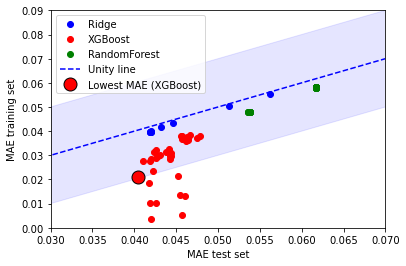

In [146]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(-Grid_rid2.cv_results_["mean_test_score"]),pd.Series(-Grid_rid2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(-Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(-Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(-Grid_ran2.cv_results_["mean_test_score"]),pd.Series(-Grid_ran2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot(C.Test,C.Train,'og')
plt.plot([0.0,0.1],[0.0,0.1],'--b')
plt.fill_between([0.0,0.1],[0.02,0.12],[-0.02,0.08],color='blue',alpha=0.1,label="_nolegend_")
plt.plot(B.Test[np.argmin(B.Test)],B.Train[np.argmin(B.Test)],'ro',markersize=13,mec="black")
plt.xlim([0.03,0.07])
plt.ylim([0.0,0.09])
plt.xlabel("MAE test set")
plt.ylabel("MAE training set")
plt.legend(["Ridge","XGBoost","RandomForest","Unity line","Lowest MAE (XGBoost)"], loc="upper left")

In [147]:
#(The shaded blue region represent a sort of confidence interval for under/overfitting:)
#(Points closer to the unity line represent cases where models are not overfitting data i.e. training and validation errors are similar)
#(Points outside the shaded blue region represent cases where models are overfitting data i.e. training and validation errors are distant from each other)

#The XGBoost model with the largest accuracy is not overfitting drastically

#Let's further tune RandomForest Hyperparameters
#Hyperparameter grid
Params_xgb = {"n_estimators":[300], "max_depth":[3,4], "learning_rate":[0.3], "min_split_loss":[0,0.01,0.02],"subsample":[0.7,0.8], "seed":[0]}

#Grid search with a 5-fold cross-validation method
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_xgb22 = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_xgb222 = Grid_xgb22.fit(X_train, y_train)

print("\nThe best XGBoost Regression Accuracy is: ",Grid_xgb222.best_params_)
print("The best XGBoost Regression Accuracy is: ",-Grid_xgb222.best_score_)


The best XGBoost Regression Accuracy is:  {'learning_rate': 0.3, 'max_depth': 3, 'min_split_loss': 0.01, 'n_estimators': 300, 'seed': 0, 'subsample': 0.8}
The best XGBoost Regression Accuracy is:  0.03986807092821617


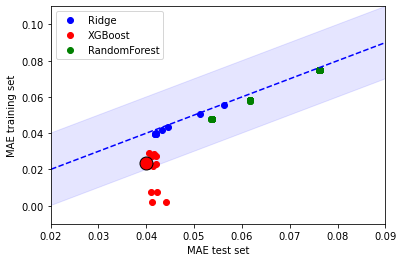

In [148]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(-Grid_rid2.cv_results_["mean_test_score"]),pd.Series(-Grid_rid2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(-Grid_xgb222.cv_results_["mean_test_score"]),pd.Series(-Grid_xgb222.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(-Grid_ran2.cv_results_["mean_test_score"]),pd.Series(-Grid_ran2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot(C.Test,C.Train,'og')
plt.plot([0.0,0.1],[0.0,0.1],'--b')
plt.fill_between([0.0,0.1],[0.02,0.12],[-0.02,0.08],color='blue',alpha=0.1)
plt.xlim([0.02,0.09])
plt.ylim([-0.01,0.11])
plt.plot(B.Test[np.argmin(B.Test)],B.Train[np.argmin(B.Test)],'ro',markersize=13,mec="black")
plt.xlabel("MAE test set")
plt.ylabel("MAE training set")
plt.legend(["Ridge","XGBoost","RandomForest"], loc="upper left")

----------------------
RMSE test (training): 32301.80 USD (13464.59 USD)
RMSLE test (training): 0.05 (0.03)
MAE test (training): 16524.46 USD (9523.18 USD)
MPE test (training): 8.37% (5.41 %)
R2 test (training): 0.93 (0.97)


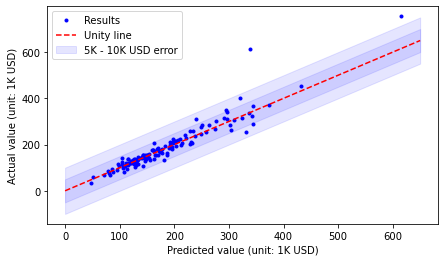

In [149]:
#The new model has a smaller MAE and overfitting is reduced

#Model training on the Training set and evaluation on the Test set
Best_xgb = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 4, min_split_loss = 0.01, n_estimators = 300, seed = 0, subsample = 0.7)
Best_model_xgb = Best_xgb.fit(X_train_t,y_train_t)        
Predictions_xgb = Best_model_xgb.predict(X_test_t)        
Predictions_xgb_tr = Best_model_xgb.predict(X_train_t)

#Definitions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_test_t)**2)/len(y_test_t))
RMSE_xgb_tr = np.sqrt(sum((10**Predictions_xgb_tr - 10**y_train_t)**2)/len(y_train_t))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y_test_t+1))**2)/len(y_test_t))
RMSLE_xgb_tr = np.sqrt(sum((np.log10(10**Predictions_xgb_tr+1) - np.log10(10**y_train_t+1))**2)/len(y_train_t))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_test_t))/len(y_test_t)
MAE_xgb_tr = sum(abs(10**Predictions_xgb_tr - 10**y_train_t))/len(y_train_t)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_test_t)/(10**y_test_t))/len(y_test_t)
MPE_xgb_tr = 100*sum(abs(10**Predictions_xgb_tr - 10**y_train_t)/(10**y_train_t))/len(y_train_t)

print("----------------------")
print("RMSE test (training): {:.2f} USD ({:.2f} USD)".format(RMSE_xgb, RMSE_xgb_tr))
print("RMSLE test (training): {:.2f} ({:.2f})".format(RMSLE_xgb, RMSLE_xgb_tr))
print("MAE test (training): {:.2f} USD ({:.2f} USD)".format(MAE_xgb, MAE_xgb_tr))
print("MPE test (training): {:.2f}% ({:.2f} %)".format(MPE_xgb,MPE_xgb_tr))
print("R2 test (training): {:.2f} ({:.2f})".format(r2_score(y_test_t,Predictions_xgb), r2_score(y_train_t,Predictions_xgb_tr)))

#Plot
plt.figure(figsize=(7,4))
plt.plot(10**Predictions_xgb/1000, 10**y_test_t/1000,'.b');
plt.xlabel("Predicted value (unit: 1K USD)")
plt.ylabel("Actual value (unit: 1K USD)")
plt.plot([0,650],[0,650],'--r')
plt.fill_between([0,650], [50,700], [-50,600], color="blue",alpha=0.1)
plt.fill_between([0,650], [100,750], [-100,550], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

.

.

## **7. Model finalization**

XGBoost model (Training)
----------------------
RMSE: 13341.60 USD
RMSLE: 0.03
MAE: 9394.02 USD
MPE: 5.35%
R2: 0.97


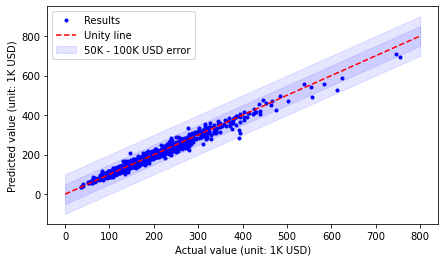

In [150]:
#Finalization of the XGBoost regression model on the whole "X_train" dataset 
#and compute RMSE, MAE, and MPE
Best_xgb = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 4, min_split_loss = 0.01, n_estimators = 300, seed = 0, subsample = 0.7)
Best_model_xgb_final = Best_xgb.fit(X_train,y_train)        
Predictions_xgb = Best_model_xgb_final.predict(X_train)        

#Defintions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_train)**2)/len(y_train))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y_train+1))**2)/len(y_train))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_train))/len(y_train)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_train)/(10**y_train))/len(y_train)

print("XGBoost model (Training)")
print("----------------------")
print("RMSE: {:.2f} USD".format(RMSE_xgb))
print("RMSLE: {:.2f}".format(RMSLE_xgb))
print("MAE: {:.2f} USD".format(MAE_xgb))
print("MPE: {:.2f}%".format(MPE_xgb))
print("R2: {:.2f}".format(r2_score(y_train,Predictions_xgb)))

#Plot the linear values
plt.figure(figsize=(7,4))
plt.plot(10**y_train/1000,10**Predictions_xgb/1000,'.b');
plt.ylabel("Predicted value (unit: 1K USD)")
plt.xlabel("Actual value (unit: 1K USD)")
plt.plot([0,800],[0,800],'--r')
plt.fill_between([0,800], [50,850], [-50,750], color="blue",alpha=0.1)
plt.fill_between([0,800], [100,900], [-100,700], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "50K - 100K USD error"], loc="upper left")

Text(0.5, 0, 'Residuals')

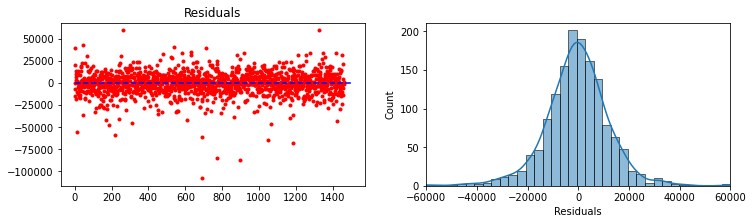

In [151]:
#Plot of the residuals
plt.figure(figsize=(12,3))  
plt.subplot(1,2,1); plt.plot(10**Predictions_xgb-10**y_train,'.r'); plt.title("Residuals"); plt.plot([0,1500],[0,0], '--b')
plt.subplot(1,2,2); sn.histplot(x = 10**Predictions_xgb-10**y_train, bins=50, kde=True); plt.xlim([-60000,60000]);plt.xlabel("Residuals")

.

.


# **8. Test on unseen data**

In [152]:
#First, the Test set must be transformed following all the procedures adopted for the Training set.
X_test, y_test = Data_transformation(Test.drop(["SalePrice"],axis=1),Test.SalePrice)

RMSE: 23818.73 USD
RMSLE: 0.06
MAE: 14715.58 USD
MPE: 8.71 %


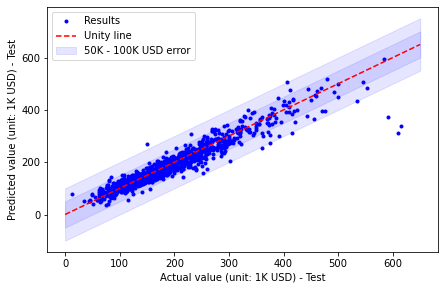

In [153]:
#XGBoost best model application
Predictions_test = Best_model_xgb_final.predict(X_test)
RMSE_linear_test = np.sqrt(sum((10**Predictions_test - 10**y_test)**2)/len(y_test))
RMSLE_linear_test = np.sqrt(sum((np.log10(10**Predictions_test+1) - np.log10(10**y_test+1))**2)/len(y_test))
MAE_linear_test = sum(abs(10**Predictions_test - 10**y_test))/len(y_test)
MPE_linear_test = 100*sum(abs(10**Predictions_test - 10**y_test)/(10**y_test))/len(y_test)
print("RMSE: {:.2f} USD".format(RMSE_linear_test))
print("RMSLE: {:.2f}".format(RMSLE_linear_test))
print("MAE: {:.2f} USD".format(MAE_linear_test))
print("MPE: {:.2f} %".format(MPE_linear_test))

#Plot
plt.figure(figsize=(7,4.5))
plt.plot(10**y_test/1000, 10**Predictions_test/1000,'.b')
plt.ylabel("Predicted value (unit: 1K USD) - Test")
plt.xlabel("Actual value (unit: 1K USD) - Test")
plt.plot([0,650],[0,650],'--r')
plt.fill_between([0,650], [50,700], [-50,600], color="blue",alpha=0.1)
plt.fill_between([0,650], [100,750], [-100,550], color="blue",alpha=0.1)
plt.legend(["Results","Unity line","50K - 100K USD error"],loc="upper left")